In [1]:
from __future__ import division
from __future__ import print_function
import hypertools as hyp
import seaborn as sns
from datetime import datetime

import numpy as np 
import pandas as pd

from pylab import plot, show, figure, imshow
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')


import sys
import os
import pickle
from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, scale
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score



import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

/homes/mamr3/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


In [2]:
#Constant Variables python
# kGroup = sys.argv[1]
# kInstrument = sys.argv[1]
# kSampleRate = 44100
# kN = 100
# kType = 'mono'
# kFeatures = 1812 #Find a way to not hard-code this.     
# path = './Music/Data/MedleyDB/Features/%s/%s/' % (sys.argv[2], kType)

kInstruments = ['bass3', 'guitar5', 'vocal2', 'keys-all3']
kLabels = ['b','g','v','k']
seed = 7
np.random.seed(seed)

# path = './Music/Data/MedleyDB/Features/%s/%s/' % (sys.argv[2], kType)
#path1 = '/homes/mamr3/Stage - 1/Music/Data/MedleyDB/Features/Analysis/' 
p = '/homes/mamr3/Stage - 1/Music/Data/MedleyDB/Features/Regression/' 
#path3 = '/homes/mamr3/Stage - 1/Music/Data/MedleyDB/Features/no_boot_nw_2000/mono/' 

def dumpPickle(d, name, _path = p):
#  path = './Music/Data/MedleyDB/Features/z_Arrays/%s/' % (kType)

  with open(_path + name, 'wb') as output:
    # Pickle dictionary using protocol 0.
    pickle.dump(d, output)
  print('%s Saved' % (name))
  
def loadPickle(name,_path = p):  
#  path = './Music/Data/MedleyDB/Features/z_Arrays/%s/' % (kType)
  # load data from pkl file
  with open(_path + name, "rb") as fp:
      loaded_data1 = pickle.load(fp)
  
  print('%s loaded, %s ' % (name, type(loaded_data1)))
  
  return loaded_data1

In [3]:
df_Raw = loadPickle('df_Raw.pkl', _path = p)
X_train = loadPickle('X_train.pkl', _path = p)
X_test = loadPickle('X_test.pkl', _path = p)
Xs_train = loadPickle('Xs_train.pkl', _path = p)
Xs_test = loadPickle('Xs_test.pkl', _path = p)
Xm_train = loadPickle('Xm_train.pkl', _path = p)
Xm_test = loadPickle('Xm_test.pkl', _path = p)
df_Stem = loadPickle('df_Stem.pkl', _path = p)
y_train = loadPickle('y_train.pkl', _path = p)
y_test = loadPickle('y_test.pkl', _path = p)

X_All = loadPickle('X_All.pkl', _path = p)
Y_All = loadPickle('y_All.pkl', _path = p)
X_Raw = loadPickle('X_Raw.pkl', _path = p)
X_Stem = loadPickle('X_Stem.pkl', _path = p)

gridResult = loadPickle('gridResult.pkl', _path = p)

gNameFeatures = loadPickle('gNameFeatures.pkl', _path = p)
gPredictionIdx = loadPickle('gPredictionIdx.pkl', _path = p)
GPredictionFeatures = loadPickle('gPredictionFeatures.pkl', _path = p)

df_Raw.pkl loaded, <class 'collections.OrderedDict'> 
X_train.pkl loaded, <class 'collections.OrderedDict'> 
X_test.pkl loaded, <class 'collections.OrderedDict'> 
Xs_train.pkl loaded, <class 'collections.OrderedDict'> 
Xs_test.pkl loaded, <class 'collections.OrderedDict'> 
Xm_train.pkl loaded, <class 'collections.OrderedDict'> 
Xm_test.pkl loaded, <class 'collections.OrderedDict'> 
df_Stem.pkl loaded, <class 'collections.OrderedDict'> 
y_train.pkl loaded, <class 'collections.OrderedDict'> 
y_test.pkl loaded, <class 'collections.OrderedDict'> 
X_All.pkl loaded, <type 'dict'> 
y_All.pkl loaded, <type 'dict'> 
X_Raw.pkl loaded, <class 'collections.OrderedDict'> 
X_Stem.pkl loaded, <class 'collections.OrderedDict'> 
gridResult.pkl loaded, <class 'collections.OrderedDict'> 
gNameFeatures.pkl loaded, <class 'collections.OrderedDict'> 
gPredictionIdx.pkl loaded, <class 'collections.OrderedDict'> 
gPredictionFeatures.pkl loaded, <class 'collections.OrderedDict'> 


In [150]:
#Gets dataframes of Predicted Feature values.

def getDFfromPickle(dataX):
    XPrediction = OrderedDict()
    gPredictionFeatures = OrderedDict()
    for k in kInstruments:
        #print '\n %s \n' % k.upper()        
        _A = dataX[k[0]][:]
        Xpreselected = [] 
        for i in gPredictionIdx[k]:

            Xpreselected.append(_A[:,i])

        XPrediction[k] = np.asarray(Xpreselected).T 

        x = []
        for f in GPredictionFeatures[k]:
            x.append('.'.join(f.split('.')[1::]))
        gPredictionFeatures[k] = x

    dfBass = pd.DataFrame(XPrediction[kInstruments[0]], columns = gPredictionFeatures[kInstruments[0]])
    dfGuitar = pd.DataFrame(XPrediction[kInstruments[1]], columns = gPredictionFeatures[kInstruments[1]])
    dfVocal = pd.DataFrame(XPrediction[kInstruments[2]], columns = gPredictionFeatures[kInstruments[2]])
    dfKeys = pd.DataFrame(XPrediction[kInstruments[3]], columns = gPredictionFeatures[kInstruments[3]])
    
    df = OrderedDict()
    df[kLabels[0]] = dfBass
    df[kLabels[1]] = dfGuitar
    df[kLabels[2]] = dfVocal
    df[kLabels[3]] = dfKeys
    
    return df

def getNPfromDF(df_R, df_S, trainSize = 0.9):
    
    A = OrderedDict()
    A_train = OrderedDict()
    A_test = OrderedDict() 
    As = OrderedDict()
    As_train = OrderedDict()
    As_test = OrderedDict() 
    Am = OrderedDict()
    Am_train = OrderedDict()
    Am_test = OrderedDict() 
    b = OrderedDict()
    b_train = OrderedDict()
    b_test = OrderedDict()
    
    
    
    
    for k in kLabels:
        
        df = df_R[k][:]
        df = df[np.abs(df-df.mean())<=(3*df.std())]
        idx = []
        for i in df.columns:
            a = pd.notnull(df[i])
            try:
                idx.append(np.where( a == False )[0][0])
                idx.append(np.where( a == False )[0][1])
            except:
                pass
        idx = list(set(idx))
        df.drop(df.index[idx], inplace=True)

        norm_df=(df-df.mean())/df.std()
        minmax_df=(df-df.min())/(df.max()-df.min())
        
        A[k] = pd.DataFrame.as_matrix(df)
        As[k] = pd.DataFrame.as_matrix(norm_df)
        Am[k] = pd.DataFrame.as_matrix(minmax_df)
        df2 = df_S[k][:]
        df2.drop(df2.index[idx], inplace=True)
        b[k] = pd.DataFrame.as_matrix(df2)
        A_train[k], A_test[k], As_train[k], As_test[k], Am_train[k], Am_test[k],b_train[k], b_test[k] = train_test_split(A[k],
                                                                                                                         As[k],
                                                                                                                         Am[k],
                                                                                                                         b[k],
                                                                                                                         train_size=trainSize,
                                                                                                                         random_state=42)
    return A_train, A_test, As_train, As_test, Am_train, Am_test, b_train, b_test

In [151]:
# X_Raw = OrderedDict()
# X_Stem = OrderedDict()
# X_Raw['b'] = XRaw['electric bass']
# X_Raw['g'] = np.vstack((XRaw['acoustic guitar'], 
#                         XRaw['clean electric guitar'], 
#                         XRaw['distorted electric guitar'], 
#                         XRaw['banjo']))
# X_Raw['v'] = np.vstack((XRaw['male singer'], 
#                         XRaw['female singer'], 
#                         XRaw['male rapper']))
# X_Raw['k'] = np.vstack((XRaw['piano'], 
#                         XRaw['synthesizer'], 
#                         XRaw['tack piano'], 
#                         XRaw['electric piano']))
# X_Stem['b'] = XStem['electric bass']
# X_Stem['g'] = np.vstack((XStem['acoustic guitar'], 
#                         XStem['clean electric guitar'], 
#                         XStem['distorted electric guitar'], 
#                         XStem['banjo']))
# X_Stem['v'] = np.vstack((XStem['male singer'], 
#                         XStem['female singer'], 
#                         XStem['male rapper']))
# X_Stem['k'] = np.vstack((XStem['piano'], 
#                         XStem['synthesizer'], 
#                         XStem['tack piano'], 
#                         XStem['electric piano']))



df_Raw = getDFfromPickle(X_Raw)
df_Stem = getDFfromPickle(X_Stem)

X_train, X_test, Xs_train, Xs_test, Xm_train, Xm_test, y_train, y_test = getNPfromDF(df_Raw, df_Stem, trainSize = 0.9)

/homes/mamr3/.local/lib/python2.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# define neural nets models

def NN_1(neurons=64, init_mode='zero', act_function='selu', dropout_rate=0.1, weight_constraint=0):
    # create model
    model = Sequential()
    model.add(Dense(neurons*2, input_dim=4, 
                    kernel_initializer=init_mode, 
                    activation=act_function, 
                    kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=act_function,
                    kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, kernel_initializer=init_mode))
    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model
# define base model

def NN_2(neurons=64,init_mode='zero', act_function='selu', dropout_rate=0.1, weight_constraint=0):
    # create model
    model = Sequential()
    model.add(Dense(neurons*2, input_dim=6,
                    kernel_initializer=init_mode, 
                    activation=act_function, 
                    kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=act_function,
                    kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, kernel_initializer=init_mode))
    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [4]:
# define random forest models

def RF_Regressor(n_estimators = 100, criterion = 'mae', max_depth=2, bootstrap=True):
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  criterion=criterion,
                                  max_depth=max_depth,
                                  bootstrap=bootstrap,
                                  n_jobs=24,
                                  random_state=None,
                                  verbose=0)
    return model
    

In [5]:
# define SVM model:

def SVR_model(kernel = 'rbf', gamma='auto', C=1.0, epsilon=0.1):
    model =  MultiOutputRegressor(SVR(kernel=kernel,
                gamma=gamma,
                C=C,
                epsilon=epsilon)) 
    return model

In [6]:
def KNN_model(n_neighbors=5, weights = 'uniform', algorithm = 'auto', p=1):
    model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=n_neighbors, 
                                weights=weights, 
                                algorithm=algorithm, 
                                p=p, 
                                n_jobs=24))
    return model

In [7]:
def Ridge_model(alpha=1.0, fit_intercept=True,normalize=False,max_iter=None,tol=0.001,solver='auto'):
    model = Ridge(alpha=alpha, 
                  fit_intercept=fit_intercept, 
                  normalize=normalize, 
                  max_iter=max_iter, 
                  tol=tol, 
                  solver=solver, 
                  random_state=seed)
    return model

In [8]:
def Linear_model(fit_intercept=True, normalize=False):
    model = LinearRegression(fit_intercept=fit_intercept, normalize=normalize, n_jobs=24)
    
    return model

In [9]:
def MLP_model(hidden_layer_sizes=(100, ),
              activation='tanh', 
              solver='adam', 
              batch_size=50, 
              max_iter=200,
             alpha=0.1,
             learning_rate='constant',
             learning_rate_init=0.001):
    
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver, 
                         alpha=alpha, 
                         batch_size=batch_size, 
                         learning_rate=learning_rate, 
                         learning_rate_init=learning_rate_init, 
                         power_t=0.5, 
                         max_iter=max_iter, 
                         shuffle=True, 
                         random_state=seed, 
                         tol=0.0001, 
                         verbose=False, 
                         warm_start=False, 
                         momentum=0.9, 
                         nesterovs_momentum=True, 
                         early_stopping=False, 
                         validation_fraction=0.1, 
                         beta_1=0.9, 
                         beta_2=0.999, 
                         epsilon=1e-08)
    
    return model

In [10]:
def PLS_model(n_components=1, scale=False, max_iter=50, tol=0.1):
    
    model = PLSRegression(n_components=n_components, scale=scale, max_iter=max_iter, tol=1e-06, copy=True)
    
    return model

In [ ]:
# Gridsearch Nerual net.

label = sys.argv[1]
gridParams = sys.argv[2]
A_train = (X_train[label])
b_train = (y_train[label])
b_test = (y_test[label])
A_test = (X_test[label])


batch_size = [10, 20, 40, 50, 60, 70]
epochs = [50, 100, 150, 200]
init_mode = ['zero','uniform','lecun_uniform', 'normal']
activation = ['selu','relu','elu','tanh','sigmoid']
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4]
neurons = [8, 16, 32, 64, 128]

if 'g' in label:

    est = KerasRegressor(build_fn=model_2, verbose=0)

else:

    est = KerasRegressor(build_fn=model_1, verbose=0)


if 'nbe' in gridParams:
    param_grid = dict(neurons=neurons,
                      batch_size=batch_size,
                      epochs=epochs)
elif 'ia' in gridParams:
    param_grid = dict(init_mode=initmode,
                      act_function=activation)
elif 'dw' in gridParams:
    param_grid = dict(dropout_rate=dropout_rate,
                      weight_constraint=weight_constraint)


grid = GridSearchCV(estimator=est, param_grid=param_grid, n_jobs=1, verbose=1)
grid_result = grid.fit(A_train, b_train)



print("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


gridResult[label+'_'+gridParams] = ("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
dumpPickle(gridResult, 'gridResult.pkl', _path = p)

In [16]:
# Grid search Random Forest

# label = sys.argv[1]
# gridParams = sys.argv[2]
label = 'k'
gridParams = 'ncbm'
A_train = (X_train[label])
b_train = (y_train[label])
b_test = (y_test[label])
A_test = (X_test[label])


n_estimators = [100,200,500,750,1000,1500,2000]
criterion = ['mae', 'mse']
max_depth=[None, 2, 3, 4, 5]
bootstrap=[True, False]


est = RF_Regressor()

if 'ncbm' in gridParams:
    param_grid = dict(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth)

    

grid = GridSearchCV(estimator=est, param_grid=param_grid, n_jobs=24, verbose=1, cv = 5)
grid_result = grid.fit(A_train, b_train)



print("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


gridResult[label+'_'+gridParams] = ("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
#dumpPickle(gridResult, 'gridResult.pkl', _path = p)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   30.4s
[Parallel(n_jobs=24)]: Done 350 out of 350 | elapsed:  1.2min finished



 label - k - Best: -0.290294 using {'n_estimators': 2000, 'criterion': 'mae', 'max_depth': 2}
-0.522832 (0.674310) with: {'n_estimators': 100, 'criterion': 'mae', 'max_depth': None}
-0.501584 (0.687442) with: {'n_estimators': 200, 'criterion': 'mae', 'max_depth': None}
-0.507300 (0.697154) with: {'n_estimators': 500, 'criterion': 'mae', 'max_depth': None}
-0.513403 (0.699457) with: {'n_estimators': 750, 'criterion': 'mae', 'max_depth': None}
-0.509644 (0.699860) with: {'n_estimators': 1000, 'criterion': 'mae', 'max_depth': None}
-0.519996 (0.703478) with: {'n_estimators': 1500, 'criterion': 'mae', 'max_depth': None}
-0.522337 (0.709933) with: {'n_estimators': 2000, 'criterion': 'mae', 'max_depth': None}
-0.309254 (0.509597) with: {'n_estimators': 100, 'criterion': 'mae', 'max_depth': 2}
-0.318743 (0.492086) with: {'n_estimators': 200, 'criterion': 'mae', 'max_depth': 2}
-0.300284 (0.483732) with: {'n_estimators': 500, 'criterion': 'mae', 'max_depth': 2}
-0.303476 (0.474624) with: {'n_

In [ ]:
# Grid search SVR

# label = sys.argv[1]
# gridParams = sys.argv[2]
label = 'k'
gridParams = 'kgce'

A_train = (X_train[label])
b_train = (y_train[label])
b_test = (y_test[label])
A_test = (X_test[label])


kernel = ['linear', 'rbf', 'sigmoid']
gamma=['auto']

for k in np.linspace(-15,3,19):
    gamma.append(np.power(2,k))
C = []
for k in np.linspace(-5,15,21):
    C.append(np.power(2,k))



epsilon=np.linspace(0,1,101)

if 'b' in label:

    est =  SVR_model(kernel='rbf',C=1.0,gamma=8.0)

elif 'g' in label:

    est =  SVR_model(kernel='rbf',C=1024,gamma=0.03125)

elif 'k' in label:

    est =  SVR_model(kernel='sigmoid',C=32768,gamma=0.000125)

elif 'v' in label:

    est =  SVR_model(kernel='sigmoid',C=64.0,gamma=0.0001)

if 'kgce' in gridParams:
    param_grid = dict(estimator__epsilon = epsilon)

    

grid = GridSearchCV(estimator=est, param_grid=param_grid, n_jobs=24, verbose=1, cv = 5)
grid_result = grid.fit(A_train, b_train)



print("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


#gridResult[label+'_'+gridParams] = ("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
#dumpPickle(gridResult, 'gridResult.pkl', _path = p)

In [ ]:
# Grid search KNN

# label = sys.argv[1]
# gridParams = sys.argv[2]
label = 'v'
gridParams = 'nwap'

A_train = (X_train[label])
b_train = (y_train[label])
b_test = (y_test[label])
A_test = (X_test[label])


n_neighbors=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
weights = ['uniform','distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
p=[1,2]


est =  KNN_model()

epsilon=np.linspace(0,1,101)

# if 'b' in label:

#     est =  SVR_model(kernel='rbf',C=1.0,gamma=8.0)

# elif 'g' in label:

#     est =  SVR_model(kernel='rbf',C=1024,gamma=0.03125)

# elif 'k' in label:

#     est =  SVR_model(kernel='sigmoid',C=32768,gamma=0.000125)

# elif 'v' in label:

#     est =  SVR_model(kernel='sigmoid',C=64.0,gamma=0.0001)

if 'nwap' in gridParams:
    param_grid = dict(estimator__n_neighbors = n_neighbors)

    

grid = GridSearchCV(estimator=est, param_grid=param_grid, n_jobs=24, verbose=1, cv = 5, scoring = 'r2')
grid_result = grid.fit(A_train, b_train)



print("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


#gridResult[label+'_'+gridParams] = ("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
#dumpPickle(gridResult, 'gridResult.pkl', _path = p)

In [ ]:
# Grid search Ridge

# label = sys.argv[1]
# gridParams = sys.argv[2]
label = 'v'
gridParams = 'afns'

A_train = (X_train[label])
b_train = (y_train[label])
b_test = (y_test[label])
A_test = (X_test[label])


 
alpha=[]
for k in np.linspace(-5,15,21):
    alpha.append(1/np.power(2,k))
fit_intercept=[True,False]
normalize=[False,True]
max_iter=None,
tol=0.001,
solver=['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']


est =  Ridge_model()

epsilon=np.linspace(0,1,101)

# if 'b' in label:

#     est =  SVR_model(kernel='rbf',C=1.0,gamma=8.0)

# elif 'g' in label:

#     est =  SVR_model(kernel='rbf',C=1024,gamma=0.03125)

# elif 'k' in label:

#     est =  SVR_model(kernel='sigmoid',C=32768,gamma=0.000125)

# elif 'v' in label:

#     est =  SVR_model(kernel='sigmoid',C=64.0,gamma=0.0001)

if 'afns' in gridParams:
    param_grid = dict(alpha = alpha,
                     fit_intercept = fit_intercept,
                     normalize = normalize,
                     solver = solver)

    

grid = GridSearchCV(estimator=est, param_grid=param_grid, n_jobs=24, verbose=1, cv = 5)
grid_result = grid.fit(A_train, b_train)



print("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


#gridResult[label+'_'+gridParams] = ("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
#dumpPickle(gridResult, 'gridResult.pkl', _path = p)

In [ ]:
# Grid search linear regression

# label = sys.argv[1]
# gridParams = sys.argv[2]
label = 'v'
gridParams = 'fn'

A_train = (X_train[label])
b_train = (y_train[label])
b_test = (y_test[label])
A_test = (X_test[label])


 

fit_intercept=[True,False]
normalize=[False,True]


est =  Linear_model()


# if 'b' in label:

#     est =  SVR_model(kernel='rbf',C=1.0,gamma=8.0)

# elif 'g' in label:

#     est =  SVR_model(kernel='rbf',C=1024,gamma=0.03125)

# elif 'k' in label:

#     est =  SVR_model(kernel='sigmoid',C=32768,gamma=0.000125)

# elif 'v' in label:

#     est =  SVR_model(kernel='sigmoid',C=64.0,gamma=0.0001)

if 'fn' in gridParams:
    param_grid = dict(fit_intercept = fit_intercept,
                     normalize = normalize)

    

grid = GridSearchCV(estimator=est, param_grid=param_grid, n_jobs=24, verbose=1, cv = 5)
grid_result = grid.fit(A_train, b_train)



print("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


#gridResult[label+'_'+gridParams] = ("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
#dumpPickle(gridResult, 'gridResult.pkl', _path = p)

In [ ]:
# Grid search MLP

# label = sys.argv[1]
# gridParams = sys.argv[2]
label = 'v'
gridParams = 'as'

A_train = (X_train[label])
b_train = (y_train[label])
b_test = (y_test[label])
A_test = (X_test[label])


 
batch_size = [10, 20, 40, 50, 60, 70]
hidden_layer_sizes=[(64, ),(64,2 ),(64,3 ),(64,4 ),(64,5 ),(256, ),(256, 2),(256,3 ),(256,4 ),(256,5 )] 
max_iter = [50,75,100,125,150,175,200,250,1000,2000]
activation=['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']

learning_rate = ['constant', 'invscaling', 'adaptive']

alpha = [0.0001, 0.001, 0.01, 0.1]
learning_rate_init  = [0.0001, 0.001, 0.01, 0.1]




if 'b' in label:

    est =  MLP_model(hidden_layer_sizes=(64,),activation='logistic', batch_size=20, max_iter=125)

elif 'g' in label:

    est =  MLP_model(hidden_layer_sizes=(64,),activation='logistic', batch_size=50, max_iter=150)

elif 'k' in label:

    est =  MLP_model(hidden_layer_sizes=(256,4),activation='logistic', batch_size=40, max_iter=150, learning_rate_init=0.1)

elif 'v' in label:

    est =  MLP_model(hidden_layer_sizes=(64,),activation='tanh', batch_size=10, max_iter=125)

if 'as' in gridParams:
    param_grid = dict(hidden_layer_sizes=hidden_layer_sizes)

    

grid = GridSearchCV(estimator=est, param_grid=param_grid, n_jobs=32, verbose=1, cv = 5)
grid_result = grid.fit(A_train, b_train)



print("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


#gridResult[label+'_'+gridParams] = ("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
#dumpPickle(gridResult, 'gridResult.pkl', _path = p)


In [ ]:
# Grid search PLS

# label = sys.argv[1]
# gridParams = sys.argv[2]
label = 'v'
gridParams = 'as'

A_train = (X_train[label])
b_train = (y_train[label])
b_test = (y_test[label])
A_test = (X_test[label])


n_components=[1,2,3,4]
scale=[True,False]  
max_iter = [50,75,100,125,150,175,200,250,1000,2000]
tol = [0.0000001, 0.00001,0.00001, 0.0001, 0.001, 0.01, 0.1]





if 'b' in label:

    est =  PLSRegression() 
elif 'g' in label:

    est =  PLSRegression()

elif 'k' in label:

    est =  PLSRegression()
    
elif 'v' in label:

    est =  PLSRegression()
    
if 'as' in gridParams:
    param_grid = dict(tol=tol,
                     max_iter=max_iter,
                     scale=scale,
                     n_components=n_components)

    

grid = GridSearchCV(estimator=est, param_grid=param_grid, n_jobs=32, verbose=1, cv = 5)
grid_result = grid.fit(A_train, b_train)



print("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


#gridResult[label+'_'+gridParams] = ("\n label - %s - Best: %f using %s" % (label, grid_result.best_score_, grid_result.best_params_))
#dumpPickle(gridResult, 'gridResult.pkl', _path = p)


In [11]:
def train_Models(label):
    
    A_train = (X_train[label])
    As_train = (Xs_train[label])
    b_train = (y_train[label])
    b_test = (y_test[label])
    A_test = (X_test[label])
    
    if 'b' in label:

#         est_1 = NN_1()
        est_2 = RF_Regressor(n_estimators = 1000)
        est_3 = SVR_model(kernel='rbf',C=1.0,gamma=8.0,epsilon=0.002)
        est_4 = KNN_model(n_neighbors=6)
        est_5 = Ridge_model(alpha = 0.125, solver = 'lsqr')
        est_6 = Linear_model()
        est_7 = MLP_model(hidden_layer_sizes=(64,),activation='logistic', batch_size=20, max_iter=125)
        est_8 =  PLSRegression(n_components=1, scale=False, max_iter=50, tol=0.01)

    elif 'g' in label:

#         est_1 = NN_2()
        est_2 = RF_Regressor(n_estimators = 750 )
        est_3 = SVR_model(kernel='rbf',C=1024,gamma=0.03125,epsilon=0.14999999)
        est_4 = KNN_model(n_neighbors=19)
        est_5 = Ridge_model(alpha = 2, solver = 'sag')
        est_6 = Linear_model()
        est_7 =  MLP_model(hidden_layer_sizes=(64,),activation='logistic', batch_size=50, max_iter=150)
        est_8 =  PLSRegression(n_components=1, scale=False, max_iter=50, tol=0.1)

    elif 'k' in label:

#         est_1 = NN_1()
        est_2 = RF_Regressor(n_estimators = 2000)
        est_3 = SVR_model(kernel='sigmoid',C=32768,gamma=0.000125,epsilon=0.29999999)
        est_4 = KNN_model(n_neighbors=5)
        est_5 = Ridge_model(alpha = 0.25, solver = 'sag')
        est_6 = Linear_model()
        est_7 =  MLP_model(hidden_layer_sizes=(256,4),activation='logistic', batch_size=40, max_iter=150,
                         learning_rate_init=0.1)
        est_8 =  PLSRegression(n_components=4, scale=False, max_iter=50, tol=0.1)

    elif 'v' in label:

#         est_1 = NN_1()
        est_2 = RF_Regressor(n_estimators = 1000)
        est_3 = SVR_model(kernel='sigmoid',C=64.0,gamma=0.0001,epsilon=0.73)
        est_4 = KNN_model(n_neighbors=13)
        est_5 = Ridge_model(alpha = 32, solver = 'sparse_cg')
        est_6 = Linear_model()
        est_7 = MLP_model(hidden_layer_sizes=(64,),activation='tanh', batch_size=10, max_iter=125)
        est_8 = PLSRegression(n_components=1, scale=False, max_iter=50, tol=0.0000001)

    
#     est_1.fit(A_train, b_train, epochs=200, batch_size=40)
    est_2.fit(A_train, b_train)
    est_3.fit(A_train, b_train)
    est_4.fit(A_train, b_train)
    est_5.fit(A_train, b_train)
    est_6.fit(A_train, b_train)
    est_7.fit(A_train, b_train)
    est_8.fit(A_train, b_train)
    
    return est_2, est_3, est_4, est_5, est_6, est_7, est_8
    
    
    
    
    
    

In [34]:
def test_models(m2, m3, m4, m7, label):
    
#     metrics_1 = {}
    metrics_2 = {}
    metrics_3 = {}
    metrics_4 = {}
#     metrics_5 = {}
#     metrics_6 = {}
    metrics_7 = {}
#     metrics_8 = {}
    metrics_all = {}
#     metrics_noNN = {}
#     metrics_all2 = {}
    
    r2 = []
    mae = []
    mse = []
    mdae = []
    evs = []
    
#     y_pred_1 = m1.predict(X_test[label])
    y_pred_2 = m2.predict(X_test[label])
    y_pred_3 = m3.predict(X_test[label])
    y_pred_4 = m4.predict(X_test[label])
#     y_pred_5 = m5.predict(X_test[label])
#     y_pred_6 = m6.predict(X_test[label])
    y_pred_7 = m7.predict(X_test[label])
#     y_pred_8 = m8.predict(X_test[label])
    
    for f in range(y_pred_2.shape[0]):
        
        y_pred = np.vstack((y_pred_2[f,:], y_pred_3[f,:],y_pred_4[f,:], y_pred_7[f,:]))
        r2.append(r2_score(y_test[label][f,:],np.mean(y_pred, axis=0)))
        mae.append(mean_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
        mdae.append(median_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
        mse.append(mean_squared_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
        evs.append(explained_variance_score(y_test[label][f,:],np.mean(y_pred, axis=0)))

    metrics_all['r2'] = np.mean(r2) 
    metrics_all['mae'] = np.mean(mae) 
    metrics_all['mdae'] = np.mean(mdae)
    metrics_all['mse'] = np.mean(mse) 
    metrics_all['evs'] = np.mean(evs) 
    
#     r2 = []
#     mae = []
#     mse = []
#     mdae = []
#     evs = []
    
#     for f in range(y_pred_1.shape[0]):
        
#         y_pred = np.vstack((y_pred_2[f,:], y_pred_3[f,:],y_pred_4[f,:], y_pred_5[f,:], y_pred_6[f,:], y_pred_7[f,:], y_pred_8[f,:]))
#         r2.append(r2_score(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mae.append(mean_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mdae.append(median_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mse.append(mean_squared_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         evs.append(explained_variance_score(y_test[label][f,:],np.mean(y_pred, axis=0)))

#     metrics_all2['r2'] = np.mean(r2) 
#     metrics_all2['mae'] = np.mean(mae) 
#     metrics_all2['mdae'] = np.mean(mdae)
#     metrics_all2['mse'] = np.mean(mse) 
#     metrics_all2['evs'] = np.mean(evs) 
    
#     r2 = []
#     mae = []
#     mse = []
#     mdae = []
#     evs = []
    
#     for f in range(y_pred_1.shape[0]):
        
#         y_pred = np.vstack((y_pred_2[f,:], y_pred_3[f,:],y_pred_4[f,:], y_pred_5[f,:], y_pred_6[f,:]))
#         r2.append(r2_score(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mae.append(mean_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mdae.append(median_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mse.append(mean_squared_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         evs.append(explained_variance_score(y_test[label][f,:],np.mean(y_pred, axis=0)))

#     metrics_noNN['r2'] = np.mean(r2) 
#     metrics_noNN['mae'] = np.mean(mae) 
#     metrics_noNN['mdae'] = np.mean(mdae)
#     metrics_noNN['mse'] = np.mean(mse) 
#     metrics_noNN['evs'] = np.mean(evs)
    
    for i in range(4):
        
        r2 = []
        mae = []
        mse = []
        mdae = []
        evs = []

        if i == 0:
            y_pred = y_pred_2
        elif i == 1:
            y_pred = y_pred_3
        elif i == 2:
            y_pred = y_pred_4
        elif i == 3:
            y_pred = y_pred_7


        
        for f in range(y_pred.shape[0]):

            r2.append(r2_score(y_test[label][f,:],y_pred[f]))
            mae.append(mean_absolute_error(y_test[label][f,:],y_pred[f]))
            mdae.append(median_absolute_error(y_test[label][f,:],y_pred[f]))
            mse.append(mean_squared_error(y_test[label][f,:],y_pred[f]))
            evs.append(explained_variance_score(y_test[label][f,:],y_pred[f]))


        if i == 0:
            metrics_2['r2'] = np.mean(r2) 
            metrics_2['mae'] = np.mean(mae) 
            metrics_2['mdae'] = np.mean(mdae)
            metrics_2['mse'] = np.mean(mse) 
            metrics_2['evs'] = np.mean(evs)
        elif i == 1:
            metrics_3['r2'] = np.mean(r2) 
            metrics_3['mae'] = np.mean(mae) 
            metrics_3['mdae'] = np.mean(mdae)
            metrics_3['mse'] = np.mean(mse) 
            metrics_3['evs'] = np.mean(evs)
        elif i == 2:
            metrics_4['r2'] = np.mean(r2) 
            metrics_4['mae'] = np.mean(mae) 
            metrics_4['mdae'] = np.mean(mdae)
            metrics_4['mse'] = np.mean(mse) 
            metrics_4['evs'] = np.mean(evs)
        elif i == 3:
            metrics_7['r2'] = np.mean(r2) 
            metrics_7['mae'] = np.mean(mae) 
            metrics_7['mdae'] = np.mean(mdae)
            metrics_7['mse'] = np.mean(mse) 
            metrics_7['evs'] = np.mean(evs)


    
    metrics = np.vstack((np.asarray(metrics_2.values()),
                         np.asarray(metrics_3.values()),
                         np.asarray(metrics_4.values()),
                         np.asarray(metrics_7.values()),
                         np.asarray(metrics_all.values()),
                         ))
    
    df = pd.DataFrame({'1':['RF','SVR','KNN','MLP','All'],
                  'mdae':metrics[:,0],
                  'mse':metrics[:,1],
                  'evs':metrics[:,2],
                  'mae':metrics[:,3],
                  'r2':metrics[:,4]})
    
    return df
    


    
    
    
    

In [35]:
label='b'
m2, m3, m4, m7 = train_Models(label)
df_b_metrics = test_models(m2, m3, m4, m7, label)
label='g'
m2, m3, m4, m7 = train_Models(label)
df_g_metrics = test_models(m2, m3, m4, m7, label)
label='k'
m2, m3, m4, m7 = train_Models(label)
df_k_metrics = test_models(m2, m3, m4, m7, label)
label='v'
m2, m3, m4, m7 = train_Models(label)
df_v_metrics = test_models(m2, m3, m4, m7, label)




In [36]:
df_b_metrics

,1,evs,mae,mdae,mse,r2
0,RF,0.996676,0.186104,0.042960,0.144134,0.995604
1,SVR,0.995804,0.204749,0.039037,0.182462,0.994584
2,KNN,0.996286,0.193999,0.049722,0.151321,0.995323
3,MLP,0.996913,0.183375,0.061897,0.134449,0.995943
4,All,0.996535,0.189643,0.043649,0.148032,0.995515


In [37]:
df_g_metrics

,1,evs,mae,mdae,mse,r2
0,RF,0.979834,0.223606,0.072670,0.261983,0.974060
1,SVR,0.983366,0.204921,0.059298,0.226928,0.978494
2,KNN,0.976317,0.234184,0.053800,0.330501,0.969994
3,MLP,0.967299,0.285596,0.073682,0.446637,0.958405
4,All,0.980892,0.209495,0.066721,0.246867,0.975340


In [38]:
df_k_metrics

,1,evs,mae,mdae,mse,r2
0,RF,0.946357,1.353325,0.006846,9.810449,0.928337
1,SVR,0.951894,1.386238,0.010818,9.352239,0.935792
2,KNN,0.939148,1.577163,0.007867,11.831026,0.918719
3,MLP,0.951126,1.294188,0.006663,8.607771,0.934706
4,All,0.948865,1.375463,0.007506,9.523986,0.931706


In [39]:
df_v_metrics

,1,evs,mae,mdae,mse,r2
0,RF,0.737848,0.636384,0.017053,1.951945,0.650485
1,SVR,0.841453,0.533299,0.017001,1.511540,0.787839
2,KNN,0.845130,0.513988,0.021402,1.396164,0.793595
3,MLP,0.774540,0.525315,0.030443,1.568261,0.701578
4,All,0.806588,0.539954,0.020663,1.492091,0.742421


In [15]:
# # Bass
# label = 'b'
# #%matplotlib inline
# fig = plt.figure(figsize=(15, 8))
# hyp.plot(pd.concat([df_Raw[label], df_Stem[label]]),
#          ['o','^'],
#          group = np.concatenate((np.zeros(68),np.ones(68))),
#          #normalize = 'within',
#          legend = ['raw','stem'],
#          ndims = 2,
#          model = 'Isomap',
#          save_path='test-image.pdf'
#          #explore = True,
#          #animate = True, duration = 30, tail_duration = 10
#         )

def plotData(label, path, ndims=2, model='PCA'):
    X = np.concatenate((X_train[label],y_train[label]))
    #X = pd.concat([df_Raw[label], df_Stem[label]])
    k = int(X.shape[0]/2)
    hyp.plot(X,
         ['o','o'],
         group = np.concatenate((np.zeros(k),np.ones(k))),
         normalize = 'within',
         #legend = ['raw','stem'],
         ndims = ndims,
         model = 'PCA',
#         model_params= {'random_state':seed}
#          save_path=path
        )
    
    

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) 


def test_models(m2, m3, m4, m7, label):
    
#     metrics_1 = {}
    metrics_2 = {}
    metrics_3 = {}
    metrics_4 = {}
#     metrics_5 = {}
#     metrics_6 = {}
    metrics_7 = {}
#     metrics_8 = {}
    metrics_all = {}
#     metrics_noNN = {}
#     metrics_all2 = {}
    
    r2 = []
    mae = []
    mse = []
    mdae = []
    mape = []
    
#     y_pred_1 = m1.predict(X_test[label])
    y_pred_2 = m2.predict(Xs_test[label])
    y_pred_3 = m3.predict(Xs_test[label])
    y_pred_4 = m4.predict(Xs_test[label])
#     y_pred_5 = m5.predict(X_test[label])
#     y_pred_6 = m6.predict(X_test[label])
    y_pred_7 = m7.predict(Xs_test[label])
#     y_pred_8 = m8.predict(X_test[label])
    
    for f in range(y_pred_2.shape[0]):
        
        y_pred = np.vstack((y_pred_2[f,:], y_pred_3[f,:],y_pred_4[f,:], y_pred_7[f,:]))
        r2.append(r2_score(y_test[label][f,:],np.mean(y_pred, axis=0),multioutput='raw_values'))
        mae.append(mean_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
        mdae.append(median_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
        mse.append(mean_squared_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
        mape.append(mean_absolute_percentage_error(y_test[label][f,:],np.mean(y_pred, axis=0)))

    metrics_all['r2'] = (r2) 
    metrics_all['mae'] = (mae) 
    metrics_all['mdae'] = (mdae)
    metrics_all['mse'] = (mse) 
    metrics_all['mape'] = (mape) 
    
#     r2 = []
#     mae = []
#     mse = []
#     mdae = []
#     evs = []
    
#     for f in range(y_pred_1.shape[0]):
        
#         y_pred = np.vstack((y_pred_2[f,:], y_pred_3[f,:],y_pred_4[f,:], y_pred_5[f,:], y_pred_6[f,:], y_pred_7[f,:], y_pred_8[f,:]))
#         r2.append(r2_score(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mae.append(mean_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mdae.append(median_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mse.append(mean_squared_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         evs.append(explained_variance_score(y_test[label][f,:],np.mean(y_pred, axis=0)))

#     metrics_all2['r2'] = np.mean(r2) 
#     metrics_all2['mae'] = np.mean(mae) 
#     metrics_all2['mdae'] = np.mean(mdae)
#     metrics_all2['mse'] = np.mean(mse) 
#     metrics_all2['evs'] = np.mean(evs) 
    
#     r2 = []
#     mae = []
#     mse = []
#     mdae = []
#     evs = []
    
#     for f in range(y_pred_1.shape[0]):
        
#         y_pred = np.vstack((y_pred_2[f,:], y_pred_3[f,:],y_pred_4[f,:], y_pred_5[f,:], y_pred_6[f,:]))
#         r2.append(r2_score(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mae.append(mean_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mdae.append(median_absolute_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         mse.append(mean_squared_error(y_test[label][f,:],np.mean(y_pred, axis=0)))
#         evs.append(explained_variance_score(y_test[label][f,:],np.mean(y_pred, axis=0)))

#     metrics_noNN['r2'] = np.mean(r2) 
#     metrics_noNN['mae'] = np.mean(mae) 
#     metrics_noNN['mdae'] = np.mean(mdae)
#     metrics_noNN['mse'] = np.mean(mse) 
#     metrics_noNN['evs'] = np.mean(evs)
    
    for i in range(4):
        
        r2 = []
        mae = []
        mse = []
        mdae = []
        mape = []

        if i == 0:
            y_pred = y_pred_2
        elif i == 1:
            y_pred = y_pred_3
        elif i == 2:
            y_pred = y_pred_4
        elif i == 3:
            y_pred = y_pred_7


        
        for f in range(y_pred.shape[0]):

            r2.append(r2_score(y_test[label][f,:],y_pred[f],multioutput='raw_values'))
            mae.append(mean_absolute_error(y_test[label][f,:],y_pred[f]))
            mdae.append(median_absolute_error(y_test[label][f,:],y_pred[f]))
            mse.append(mean_squared_error(y_test[label][f,:],y_pred[f]))
            mape.append(mean_absolute_percentage_error(y_test[label][f,:],y_pred[f]))


        if i == 0:
            metrics_2['r2'] = (r2) 
            metrics_2['mae'] = (mae) 
            metrics_2['mdae'] = (mdae)
            metrics_2['mse'] = (mse) 
            metrics_2['mape'] = (mape)
        elif i == 1:
            metrics_3['r2'] = (r2) 
            metrics_3['mae'] = (mae) 
            metrics_3['mdae'] = (mdae)
            metrics_3['mse'] = (mse) 
            metrics_3['mape'] = (mape)
        elif i == 2:
            metrics_4['r2'] = (r2) 
            metrics_4['mae'] = (mae) 
            metrics_4['mdae'] = (mdae)
            metrics_4['mse'] = (mse) 
            metrics_4['mape'] = (mape)
        elif i == 3:
            metrics_7['r2'] = (r2) 
            metrics_7['mae'] = (mae) 
            metrics_7['mdae'] = (mdae)
            metrics_7['mse'] = (mse) 
            metrics_7['mape'] = (mape)


    
#     metrics = np.vstack((np.asarray(metrics_2.values()),
#                          np.asarray(metrics_3.values()),
#                          np.asarray(metrics_4.values()),
#                          np.asarray(metrics_7.values()),
#                          np.asarray(metrics_all.values()),
#                          ))
    
#     df = pd.DataFrame({'1':['RF','SVR','KNN','MLP','All'],
#                   'mdae':metrics[:,0],
#                   'mse':metrics[:,1],
#                   'evs':metrics[:,2],
#                   'mae':metrics[:,3],
#                   'r2':metrics[:,4]})
    
    return metrics_2, metrics_3, metrics_4, metrics_7, metrics_all 
    


    
    
    
    

In [19]:
label='v'
m2, m3, m4, m5, m6, m7, m8 = train_Models(label)
y_pred_2 = m2.predict(X_test[label])
y_pred_3 = m3.predict(X_test[label])
y_pred_4 = m4.predict(X_test[label])
y_pred_5 = m5.predict(X_test[label])
y_pred_6 = m6.predict(X_test[label])
y_pred_7 = m7.predict(X_test[label])
y_pred_8 = m8.predict(X_test[label])

a = []
a2 = []
rf = []
svr = []
knn = []
mlp = []
lr = []
rdg = []
pls = []
d = 4
#for f in range(y_pred_2.shape[1]):
for f in [0,1,2]:

    _rf =  mean_absolute_percentage_error(y_test[label][:,f],y_pred_2[:,f])
    _svr =  mean_absolute_percentage_error(y_test[label][:,f],y_pred_3[:,f])
    _knn =  mean_absolute_percentage_error(y_test[label][:,f],y_pred_4[:,f])
    _lr =  mean_absolute_percentage_error(y_test[label][:,f],y_pred_6[:,f])
    _mlp =  mean_absolute_percentage_error(y_test[label][:,f],y_pred_7[:,f])
    _rdg =  mean_absolute_percentage_error(y_test[label][:,f],y_pred_5[:,f])
    _pls =  mean_absolute_percentage_error(y_test[label][:,f],y_pred_8[:,f])
    
    y_pred = np.mean(np.vstack((y_pred_6[:,f], 
                                y_pred_3[:,f])), axis=0)   

    _a = (mean_absolute_percentage_error(y_test[label][:,f],y_pred))
    
    rf.append(_rf)
    svr.append(_svr)
    knn.append(_knn)
    lr.append(_lr)
    mlp.append(_mlp)
    a.append(_a)
    rdg.append(_rdg)
    pls.append(_pls)
    
    
   
    
    
    
   # print('\n MLP: ', np.around(_mlp, decimals = d))
#     print('\n SVR: ', np.around(_svr, decimals = d))
#     print('RF: ', np.around(_rf, decimals = d))
#     print('KNN: ', np.around(_knn, decimals = d))
#     print('PLS: ', np.around(_pls, decimals = d))
    #print('RDG: ', np.around(_rdg, decimals = d))
#    print('LR: ', np.around(_lr, decimals = d))
    
#     print('All:', np.around(_a, decimals = d))
    
    




#print('\n mean-MLP:',np.around(np.mean(mlp), decimals = d))
print('\n mean-SVR:',np.around(np.mean(svr), decimals = d))
print('mean-RF:',np.around(np.mean(rf), decimals = d))
print('mean-KNN:',np.around(np.mean(knn), decimals = d))
print('mean-PLS:',np.around(np.mean(pls), decimals = d))
#print('mean-RDG:',np.around(np.mean(rdg), decimals = d))
print('mean-LR:',np.around(np.mean(lr), decimals = d))

print('mean-All:',np.around(np.mean(a), decimals = d))


 mean-SVR: 0.1796
mean-RF: 0.1918
mean-KNN: 0.1831
mean-PLS: 0.1759
mean-LR: 0.1536
mean-All: 0.1395


In [173]:
label='k'
m2, m3, m4, m5, m6, m7, m8 = train_Models(label)
y_pred_2 = m2.predict(X_test[label])
y_pred_3 = m3.predict(X_test[label])
y_pred_4 = m4.predict(X_test[label])
y_pred_5 = m5.predict(X_test[label])
y_pred_6 = m6.predict(X_test[label])
y_pred_7 = m7.predict(X_test[label])
y_pred_8 = m8.predict(X_test[label])

a = []
a2 = []
rf = []
svr = []
knn = []
mlp = []
lr = []
rdg = []
pls = []
d = 10
for f in range(y_pred_2.shape[1]):
#for f in [0,1,2]:

    _rf =  mean_absolute_error(y_test[label][:,f],y_pred_2[:,f])
    _svr =  mean_absolute_error(y_test[label][:,f],y_pred_3[:,f])
    _knn =  mean_absolute_error(y_test[label][:,f],y_pred_4[:,f])
    _lr =  mean_absolute_error(y_test[label][:,f],y_pred_6[:,f])
    _mlp =  mean_absolute_error(y_test[label][:,f],y_pred_7[:,f])
    _rdg =  mean_absolute_error(y_test[label][:,f],y_pred_5[:,f])
    _pls =  mean_absolute_error(y_test[label][:,f],y_pred_8[:,f])
    
    y_pred = np.mean(np.vstack((y_pred_2[:,f], 
                                y_pred_3[:,f],
                                y_pred_4[:,f],
                                y_pred_6[:,f],
                                y_pred_8[:,f])), axis=0)   
    _a = (mean_absolute_error(y_test[label][:,f],y_pred))
    
    rf.append(_rf)
    svr.append(_svr)
    knn.append(_knn)
    lr.append(_lr)
    mlp.append(_mlp)
    a.append(_a)

    rdg.append(_rdg)
    pls.append(_pls)
    
    
    #print('\n MLP: ', np.around(_mlp, decimals = d))
#     print('\n SVR: ', np.around(_svr, decimals = d))
#     print('RF: ', np.around(_rf, decimals = d))
#     print('KNN: ', np.around(_knn, decimals = d))
#     print('PLS: ', np.around(_pls, decimals = d))
#     print('RDG: ', np.around(_rdg, decimals = d))
    print('LR: ', np.around(_lr, decimals = d))
    
#     print('All:', np.around(_a, decimals = d))
    
    




#print('\n mean-MLP:',np.around(np.mean(mlp), decimals = d))
print('mean-SVR:',np.around(np.mean(svr), decimals = d))
print('mean-RF:',np.around(np.mean(rf), decimals = d))
print('mean-KNN:',np.around(np.mean(knn), decimals = d))
print('mean-PLS:',np.around(np.mean(pls), decimals = d))
print('mean-RDG:',np.around(np.mean(rdg), decimals = d))
#print('mean-LR:',np.around(np.mean(lr), decimals = d))

print('mean-All:',np.around(np.mean(a), decimals = d))

LR:  7.4014e-06
LR:  0.0102466812
LR:  5.386338887
LR:  0.0045677592
mean-SVR: 1.3862383574
mean-RF: 1.3471967189
mean-KNN: 1.57716
mean-PLS: 1.3502952167
mean-RDG: 1.4458042509
mean-All: 1.3821975397


In [17]:
label='k'
m2, m3, m4, m5, m6, m7, m8 = train_Models(label)
y_pred_2 = m2.predict(X_test[label])
y_pred_3 = m3.predict(X_test[label])
y_pred_4 = m4.predict(X_test[label])
y_pred_5 = m5.predict(X_test[label])
y_pred_6 = m6.predict(X_test[label])
y_pred_7 = m7.predict(X_test[label])
y_pred_8 = m8.predict(X_test[label])

a = []
a2 = []
rf = []
svr = []
knn = []
mlp = []
lr = []
rdg = []
pls = []
d = 4
#for f in range(y_pred_2.shape[1]):
for f in [2]:

    _rf =  r2_score(y_test[label][:,f],y_pred_2[:,f])
    _svr =  r2_score(y_test[label][:,f],y_pred_3[:,f])
    _knn =  r2_score(y_test[label][:,f],y_pred_4[:,f])
    _lr =  r2_score(y_test[label][:,f],y_pred_6[:,f])
    _mlp =  r2_score(y_test[label][:,f],y_pred_7[:,f])
    _rdg =  r2_score(y_test[label][:,f],y_pred_5[:,f])
    _pls =  r2_score(y_test[label][:,f],y_pred_8[:,f])
    
    y_pred = np.mean(np.vstack((y_pred_3[:,f], 
                                y_pred_6[:,f])), axis=0)   
    _a = (r2_score(y_test[label][:,f],y_pred))
    
    rf.append(_rf)
    svr.append(_svr)
    knn.append(_knn)
    lr.append(_lr)
    mlp.append(_mlp)
    a.append(_a)

    rdg.append(_rdg)
    pls.append(_pls)
    
    
    #print('\n MLP: ', np.around(_mlp, decimals = d))
    print('\n SVR: ', np.around(_svr, decimals = d))
    print('RF: ', np.around(_rf, decimals = d))
    print('KNN: ', np.around(_knn, decimals = d))
    print('PLS: ', np.around(_pls, decimals = d))
    print('RDG: ', np.around(_rdg, decimals = d))
    print('LR: ', np.around(_lr, decimals = d))
    
    print('All:', np.around(_a, decimals = d))
    
    




#print('\n mean-MLP:',np.around(np.mean(mlp), decimals = d))
print('mean-SVR:',np.around(np.mean(svr), decimals = d))
print('mean-RF:',np.around(np.mean(rf), decimals = d))
print('mean-KNN:',np.around(np.mean(knn), decimals = d))
print('mean-PLS:',np.around(np.mean(pls), decimals = d))
print('mean-RDG:',np.around(np.mean(rdg), decimals = d))
print('mean-LR:',np.around(np.mean(lr), decimals = d))
print('mean-All:',np.around(np.mean(a), decimals = d))







 SVR:  -0.1399
RF:  -0.2059
KNN:  -0.4421
PLS:  -0.2698
RDG:  -0.3107
LR:  -0.2698
All: -0.1833
mean-SVR: -0.1399
mean-RF: -0.2059
mean-KNN: -0.4421
mean-PLS: -0.2698
mean-RDG: -0.3107
mean-LR: -0.2698
mean-All: -0.1833


In [ ]:
def plotData(label, path, ndims=2, model='PCA'):
    X = np.concatenate((X_train[label],y_train[label]))
    #X = pd.concat([df_Raw[label], df_Stem[label]])
    k = int(X.shape[0]/2)
    hyp.plot(X,
         ['o','o'],
         group = np.concatenate((np.zeros(k),np.ones(k))),
         normalize = 'within',
         #legend = ['raw','stem'],
         ndims = ndims,
         model = 'PCA',
#         model_params= {'random_state':seed}
#          save_path=path
        )

In [40]:
label = 'b'
df1 = pd.DataFrame(X_train[label], columns = df_Raw[label].columns)     
df2 = pd.DataFrame(y_train[label], columns = df_Stem[label].columns)    

<IPython.core.display.Javascript object>


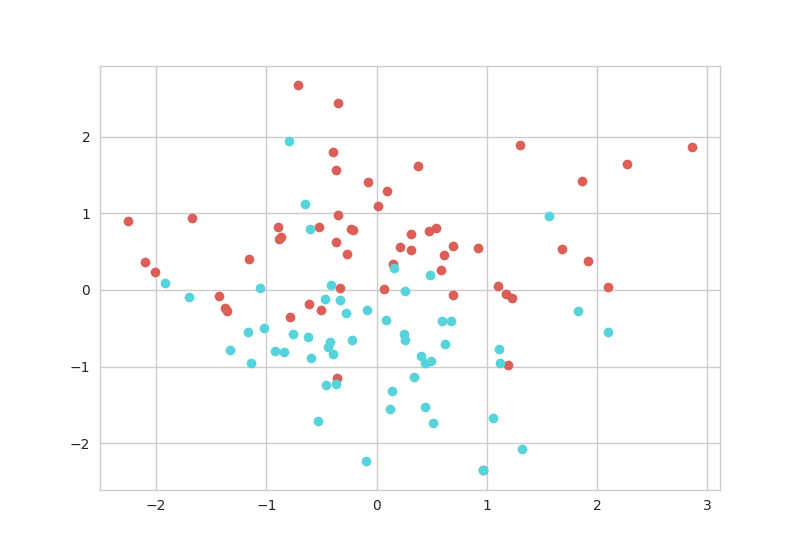

In [129]:
label = 'v'
df1 = pd.DataFrame(X_train[label], columns = df_Raw[label].columns)     
df2 = pd.DataFrame(y_train[label], columns = df_Stem[label].columns) 

if 'b' in label:
    df1.pop(df1.columns[3])
    df2.pop(df2.columns[3])
    ndims = 1

elif 'g' in label:
    df1.pop(df1.columns[0])
    df2.pop(df2.columns[0])
    df1.pop(df1.columns[0])
    df2.pop(df2.columns[0])
    df1.pop(df1.columns[0])
    df2.pop(df2.columns[0])
    df1.pop(df1.columns[0])
    df2.pop(df2.columns[0])
    
    ndims = 1

elif 'k' in label:
    df1.pop(df1.columns[0])
    df2.pop(df2.columns[0])
    df1.pop(df1.columns[0])
    df2.pop(df2.columns[0])
    df1.pop(df1.columns[1])
    df2.pop(df2.columns[1])
    ndims = 1

    

k = int(df1.shape[0])
X = pd.concat([df1, df2])
hyp.plot(X, 
         ['o','o'], 
         group = np.concatenate((np.zeros(k),np.ones(k))), 
         normalize = 'within', 
         #legend = ['raw','stem'],
         ndims = 2,
         save_path='VOCAL.png'
        )


<IPython.core.display.Javascript object>


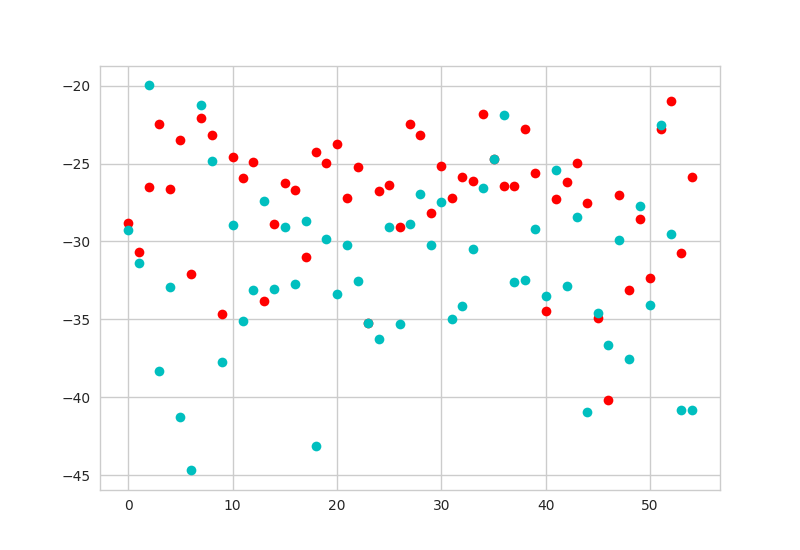

In [83]:
plot(df1 ,'ro', df2, 'co')

In [117]:
df1


,scvalleys.max.0,loudness.dmean2
0,-9.189656,0.105940
1,-7.745840,0.643168
2,-6.199524,0.545099
3,-6.071843,0.820826
4,-6.769691,0.192473
5,-7.139158,0.158611
6,-6.843369,0.822523
7,-9.204551,0.583368
8,-7.850833,1.010349
9,-7.162059,0.286647
